Practice loading in made up data

Running simulation (BasicSimulator):
• 2020-01-01 to 2020-07-18 (200 days)
• 3 geo nodes
  |####################| 100% 
Runtime: 0.207s


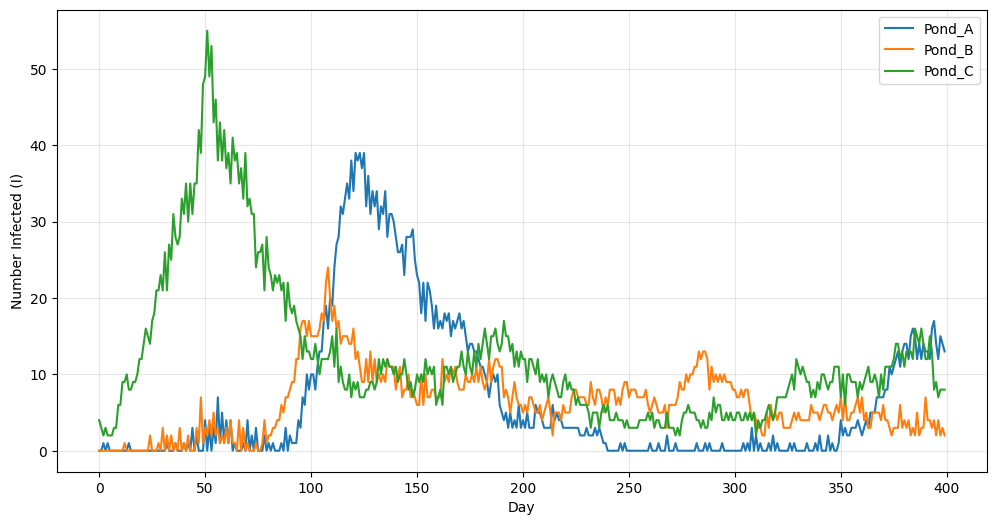

In [ ]:
# import the necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from epymorph.kit import * #noqa

from pathlib import Path

current_dir = Path("testDataMultiNode.ipynb").resolve().parent

test_data_path = current_dir.parent / "data" / "basicTestData.csv"

# load the csv file
df = pd.read_csv(test_data_path)

# build a CustomScope from the site IDs
site_ids = df["site_id"].astype(str).tolist()
scope = CustomScope(site_ids)

# build the population list for the model
population = df["n_salamanders"].to_list()

# pick a site to start the infection at.
# each site has a different I_0
seed_location_index = 2
seed_size = int(df.loc[seed_location_index, "initial_infected"])

# inits
my_init = init.SingleLocation(
    location = seed_location_index,
    seed_size = seed_size
)

# time frame
time = TimeFrame.of("2020-01-01", duration_days=200)

# choose a simple IPM
my_ipm = ipm.SIRS()

# uniform mix of all ponds in scope
movement_model = mm.Flat()

# set parameters
params = {
    "beta": 0.3,
    "gamma": 0.1,
    "xi": 1/90,
    "population": population,
}

# build the RUME
rume = SingleStrataRUME.build(
    ipm = my_ipm,
    mm = movement_model,
    init = my_init,
    scope = scope,
    time_frame = time,
    params = params,
)

# run the simulation
sim = BasicSimulator(rume)

with sim_messaging(live=False):
    out = sim.run(rng_factory=default_rng(5))

df_out = out.dataframe

ponds = out.rume.scope.node_ids

plt.figure(figsize=(12, 6))


for pond in ponds:

    pond_df = df_out[df_out["node"] == pond]
    I_series = pond_df["I"].to_numpy()
    ticks = pond_df["tick"].to_numpy()

    plt.plot(ticks, I_series, label=pond)

    if len(I_series) > 0:
        peak_idx = int(np.argmax(I_series))
        peak_tick = int(ticks[peak_idx])
        peak_val = float(I_series[peak_idx])

#plt.ylim(0, 60)
plt.xlabel("Day")
plt.ylabel("Number Infected (I)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
